In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Image Compression

In this challenge we will use **images** 🖼️ as data. 

You will use **K-means** for image compression, by reducing the colors in an image to only the most frequent ones.

## 1) Images with Python

This section should give you some understanding of how we deal with images in Python.  

**No coding required for section 1), read carefully and execute the examples provided.**

### 1.1) Black & white images

An image can be described as a matrix where each element is a pixel.  

The scale of colors is between 0 (black) and 255 (white).  

Thus, each element in the matrix will have a value between 0 and 255.

<img src="https://miro.medium.com/max/1386/1*bV7S0zACdidh11ikjYpLpQ.png">

We said `matrix`, you thought `numpy`, that's accurate 🙂  

👇 Execute the cell below to see a black and white image created only with `numpy`.

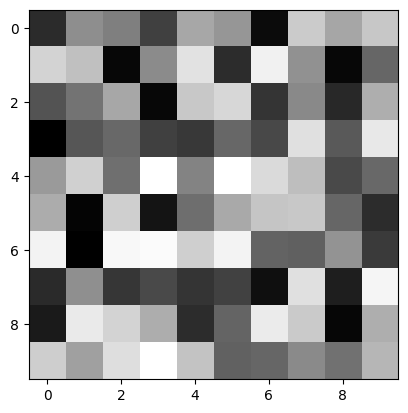

In [2]:
# Let's create  a vector of 100 elements with a value between 0 and 255
image_bw = np.random.uniform(low=0, high=255, size=100)

# Reshape it into a squared matrix, we have an image of 10x10 pixels
image_bw = image_bw.reshape((10, 10))

# Finally display the generated image
plt.imshow(image_bw, cmap='gray');

### 1.2) Colored images :

Every color is a linear combination of primary colors : Red, Green, Blue  

A colored image is just the overlay of three layers, one for each primary color.  

So for each pixel, we have three values (Red, Green, Blue).

<img src="https://miro.medium.com/max/840/1*y0nV4cWk3KbzXSe9dIWL5g.jpeg">

👇  Again, execute the cells below to see a colored image created only with `numpy`.

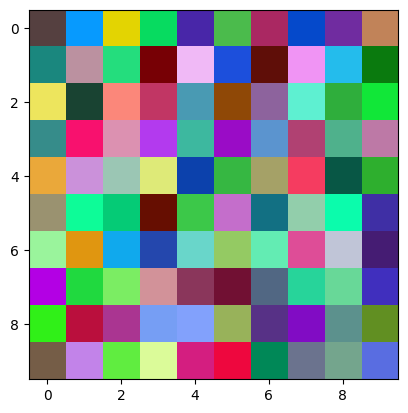

In [3]:
# Let's create vector of 100*3 elements with a value between 0 and 1
image_c = np.random.uniform(low=0., high=1., size=100*3)

# Reshape it into a squared image of 10x10 pixels with 3 colors
image_c = image_c.reshape((10, 10, 3))

# Finally display the generated image
plt.imshow(image_c);

In [4]:
image_c

array([[[0.33366904, 0.25205125, 0.25126838],
        [0.03064476, 0.60641799, 0.99890752],
        [0.8937014 , 0.83183365, 0.01012285],
        [0.02999507, 0.85956333, 0.37906041],
        [0.28509122, 0.15074596, 0.6608268 ],
        [0.2972633 , 0.73708957, 0.30047714],
        [0.66794437, 0.15948042, 0.3854265 ],
        [0.02268301, 0.28993163, 0.79718737],
        [0.44090164, 0.17598006, 0.6311613 ],
        [0.75920394, 0.51425595, 0.35154241]],

       [[0.10544269, 0.53133485, 0.4954284 ],
        [0.73560369, 0.57107197, 0.6298186 ],
        [0.14308298, 0.86937551, 0.4902848 ],
        [0.47005538, 0.00391395, 0.02087818],
        [0.94120312, 0.72769739, 0.96783042],
        [0.11210768, 0.31281264, 0.86542746],
        [0.37395124, 0.05811299, 0.03270064],
        [0.94279297, 0.58423836, 0.96040252],
        [0.14188402, 0.73857692, 0.92933902],
        [0.03964083, 0.48137691, 0.05845169]],

       [[0.93076043, 0.89868322, 0.36814633],
        [0.09893549, 0.2631731

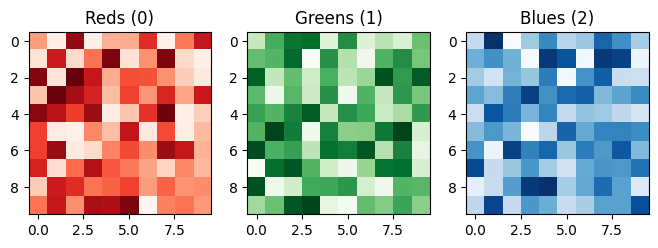

In [9]:
# To get some intuition, let's plot each color layer
fig, axs = plt.subplots(1, 3, figsize=(8, 6))
colors = {0:'Reds', 1:'Greens', 2:'Blues'}

for i in colors:
    axs[i].imshow(image_c[:, :, i], cmap=colors[i])
    axs[i].set_title(f"{colors[i]} ({i})")

## 2) Images for ML

### 2.1) Setup

Install the `skimage` library, it will give us access to classic images

In [10]:
! pip install --quiet scikit-image

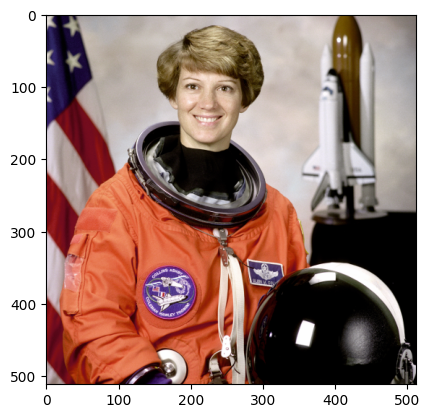

In [11]:
from skimage import data
img = data.astronaut()
plt.imshow(img);

❓ What is the shape of this image?  
Assign it to `img_shape`

In [13]:
img_shape = img.shape
img_shape

(512, 512, 3)

### 2.2) Number of colors

To make our image ready for compression, or ML in general, we need to represent it as **observations** and **features**.  

Each **pixel** is an **observation**  
Each **color value (Red, Green, Blue)** is a **feature**  

In our image, we have **262,144 observations** (512 * 512 pixels) and **3 features** (RGB)

❓ Reshape the image:  
- From its current size of `width * height * 3`
- To a matrix  of size `N * 3` where `N = width * height`  

Assign the reshaped image to `X`.

In [16]:
img[:3, :3, :3]

array([[[154, 147, 151],
        [109, 103, 124],
        [ 63,  58, 102]],

       [[177, 171, 171],
        [144, 141, 143],
        [113, 114, 124]],

       [[201, 194, 193],
        [182, 178, 175],
        [168, 165, 164]]], dtype=uint8)

In [23]:
img_reshaped = np.reshape(img, (img.shape[0] * img.shape[1], img.shape[2]))
img_reshaped.shape

(262144, 3)

In [24]:
img_reshaped[:3,:3]

array([[154, 147, 151],
       [109, 103, 124],
       [ 63,  58, 102]], dtype=uint8)

A colored image may contain up to 16 Millions potential colors.  

Indeed, for each pixel we have **3** channels, and for each channel we have **256** possible values (from 0 to 255)  
Hence a potential maximum of **16,777,216** *($256^3$)* colors in a colored image  

Since our image is only 262,144 pixels (512 * 512), it uses at most 262,144 colors, as each pixel contains a single color defined by the three channels' values

Let's count! 🕵️ 

❓ Store the number of unique colors in this picture in `color_count`

In [39]:
color_count = np.unique(img_reshaped, axis=0).shape[0]
color_count

113382

Let's break down what we have: 
- 262,144 observations, each observation is a pixel  
- 3 features (Red, Green & Blue values) for each observation
- An unknown number of clusters 😱

**Let's see what we can do to reduce the number of colors** 🎨

### 🧪 Test your code

In [40]:
from nbresult import ChallengeResult

result = ChallengeResult('image_analysis',
                         img_shape = img_shape,
                         color_count = color_count)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /home/branchedelac/.pyenv/versions/3.10.6/envs/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /home/branchedelac/code/branchedelac/05-ML/06-Unsupervised-Learning/data-image-compression/tests
plugins: anyio-3.6.2, asyncio-0.19.0, typeguard-2.13.3
asyncio: mode=strict
collecting ... collected 2 items

test_image_analysis.py::TestImageAnalysis::test_color_count PASSED       [ 50%]
test_image_analysis.py::TestImageAnalysis::test_img_shape PASSED         [100%]

============================== 2 passed in 0.03s ===============================


💯 You can commit your code:

git add tests/image_analysis.pickle

git commit -m 'Completed image_analysis step'

git push origin master



## 3) Compression with K-means

We want to reduce the **113,382** colors to **K** colors.  

Using a `KMeans` algorithm over the pixels, we can assign each pixel to one of **K** clusters!  

The center of each cluster is going to be the average color of the pixels that belong to it. 

We can then use this "mean cluster color" as the RGB values for each pixel in the cluster.  

💪🧠 Let's do it, our objective is to use only **32** colors!

❓ Fit a K-means with `n_clusters=32` on your ML-ready image `X`, and assign it to `kmeans`

In [45]:
X = img_reshaped.copy()

In [119]:
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=2)

kmeans = k_means.fit(X)

👉 Check the `labels_` of your `kmeans`, then check their `shape` and `number of unique values`

In [120]:
kmeans.labels_

array([0, 0, 1, ..., 1, 1, 1], dtype=int32)

In [121]:
kmeans.labels_.shape

(262144,)

In [122]:
np.unique(kmeans.labels_).shape

(2,)

☝️ Let's break it down:

- Each label is a cluster
- There is one label assigned to each observations
- There are a total of 32 different labels, one for each cluster

❓ Check the `cluster_centers_` of your `KMeans`, shape and first element

In [123]:
kmeans.cluster_centers_[:3]

array([[198.0162366 , 158.95785811, 145.87524156],
       [ 55.44113567,  24.60416386,  21.11409661]])

☝️Each cluster_center is a vector of RGB values, it represents the mean color of the cluster

❓ Create an array `X_compressed`, which stores for each pixel picture the mean color of its corresponding cluster.

<details span="markdown">
    <summary>💡 Help</summary>

You can achieve this by using only `kmeans.cluster_centers_` and `kmeans.labels_`

---

</details>

In [124]:
kmeans.cluster_centers_[:3]

array([[198.0162366 , 158.95785811, 145.87524156],
       [ 55.44113567,  24.60416386,  21.11409661]])

In [125]:
kmeans.labels_

array([0, 0, 1, ..., 1, 1, 1], dtype=int32)

In [126]:
print("Number of mean colors:", kmeans.cluster_centers_.shape)
print("Number of pixels:", kmeans.labels_.shape)

Number of mean colors: (2, 3)
Number of pixels: (262144,)


In [127]:
new_array = []
for label in kmeans.labels_:
    new_array.append(kmeans.cluster_centers_[label])

X_compressed = np.array(new_array)
X_compressed[:10]

array([[198.0162366 , 158.95785811, 145.87524156],
       [198.0162366 , 158.95785811, 145.87524156],
       [ 55.44113567,  24.60416386,  21.11409661],
       [ 55.44113567,  24.60416386,  21.11409661],
       [ 55.44113567,  24.60416386,  21.11409661],
       [ 55.44113567,  24.60416386,  21.11409661],
       [198.0162366 , 158.95785811, 145.87524156],
       [198.0162366 , 158.95785811, 145.87524156],
       [198.0162366 , 158.95785811, 145.87524156],
       [198.0162366 , 158.95785811, 145.87524156]])

In [128]:
print("Number of pixels", X_compressed.shape)
print("Number of unique colors:", np.unique(X_compressed, axis=0).shape)

Number of pixels (262144, 3)
Number of unique colors: (2, 3)


RGB values must be integer.  

Our colors in `X_compressed` are in `float64`.  

❓ Convert `X_compressed` to `uint8`, the unsigned 8-bits integer type which lies between 0 and 255.

In [129]:
X_compressed = X_compressed.astype(np.uint8)
X_compressed

array([[198, 158, 145],
       [198, 158, 145],
       [ 55,  24,  21],
       ...,
       [ 55,  24,  21],
       [ 55,  24,  21],
       [ 55,  24,  21]], dtype=uint8)

❓ Verify that the number of unique colors used is indeed 32.

In [130]:
np.unique(X_compressed).shape

(6,)

Almost there! 💪

## 4) Plot compressed image

Our `X_compressed` has shape (262144, 3), we can't display it as an image.

❓ Reshape your compressed image and plot it side by side with your original image.  

<details>
    <summary>💡 Hint</summary>

You need to reshape your flattened `X_compressed` into the right dimensions for an image  
Your original image has such dimensions.

---

</details>

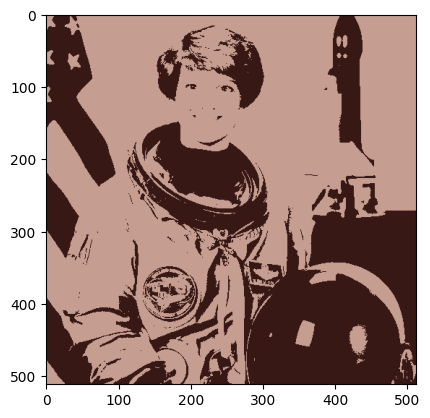

In [131]:
X_compressed_reshaped = X_compressed.reshape((512, 512, 3))
plt.imshow(X_compressed_reshaped);

Well done! 💪

Some colors are lost, but your can easily recognize the original image.

🏁 **Don't forget to push your notebook.**  

Proceed with the challenges of the day and come back here if you have time 😉

## 5 - Optional) Use the elbow method

You can try to use the Elbow method to find the optimal compression that loses the least color information.   

Try to plot the `inertia` for `n_clusters` in the list [5, 10, 20, 30, 50, 70, 100] for instance  

⚠️ Long training, you might wait several minutes

In [132]:
# YOUR CODE HERE

❓ Run the cell below to visualize your compressed image using different number of clusters  
⚠️ This is a long training, you will wait a few minutes

working with 1 clusters...
------------------------------------------------------------------------------------------------------------------------
If we compress our 113382 unique colors into 1 clusters...
The Kmeans inertia is equal to 4891993276.004078


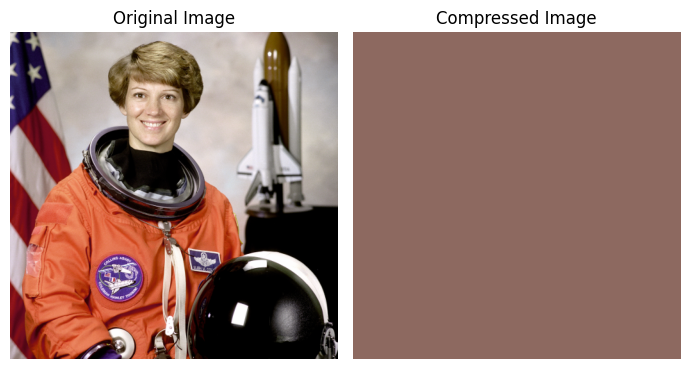

working with 2 clusters...
------------------------------------------------------------------------------------------------------------------------
If we compress our 113382 unique colors into 2 clusters...
The Kmeans inertia is equal to 1509779754.7858424


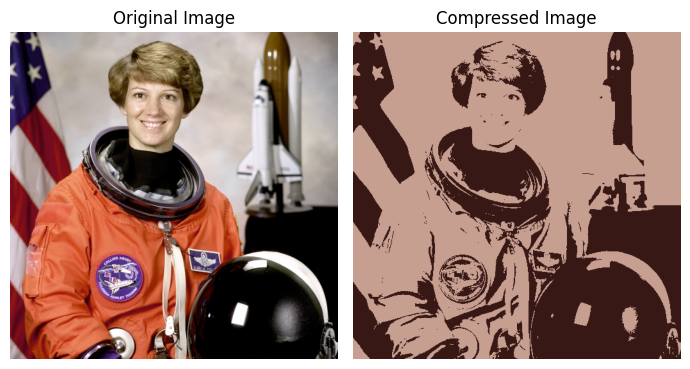

working with 5 clusters...
------------------------------------------------------------------------------------------------------------------------
If we compress our 113382 unique colors into 5 clusters...
The Kmeans inertia is equal to 377758211.9036069


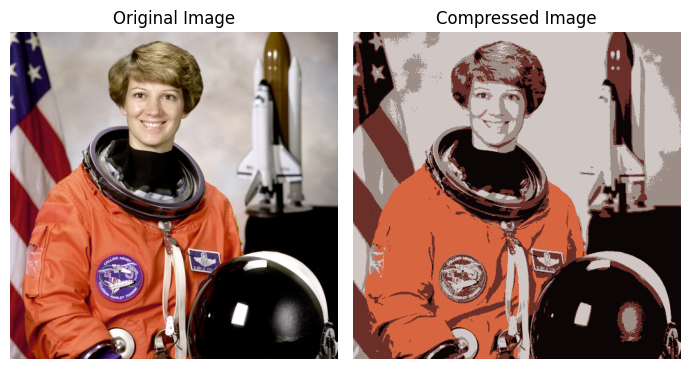

working with 10 clusters...
------------------------------------------------------------------------------------------------------------------------
If we compress our 113382 unique colors into 10 clusters...
The Kmeans inertia is equal to 158892394.14026925


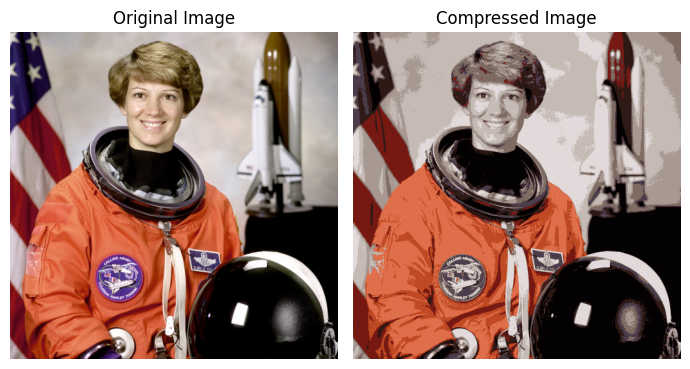

working with 20 clusters...
------------------------------------------------------------------------------------------------------------------------
If we compress our 113382 unique colors into 20 clusters...
The Kmeans inertia is equal to 71594634.58590156


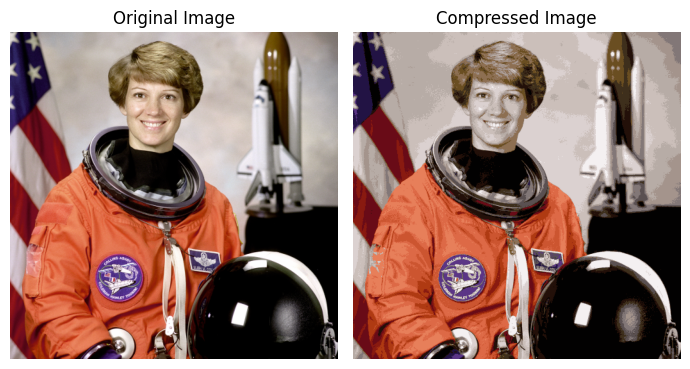

working with 30 clusters...
------------------------------------------------------------------------------------------------------------------------
If we compress our 113382 unique colors into 30 clusters...
The Kmeans inertia is equal to 46117876.87186464


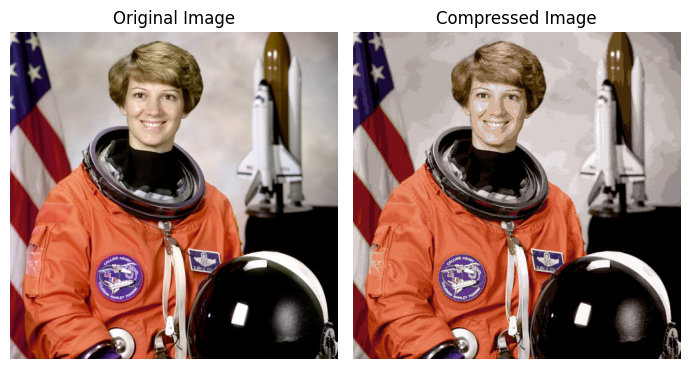

working with 50 clusters...
------------------------------------------------------------------------------------------------------------------------
If we compress our 113382 unique colors into 50 clusters...
The Kmeans inertia is equal to 28246089.18521724


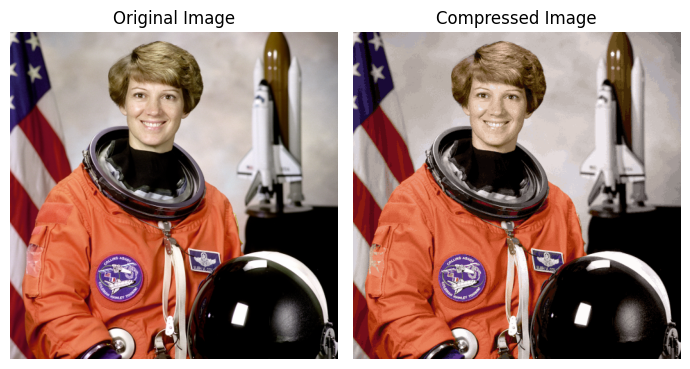

working with 70 clusters...
------------------------------------------------------------------------------------------------------------------------
If we compress our 113382 unique colors into 70 clusters...
The Kmeans inertia is equal to 20878771.236131944


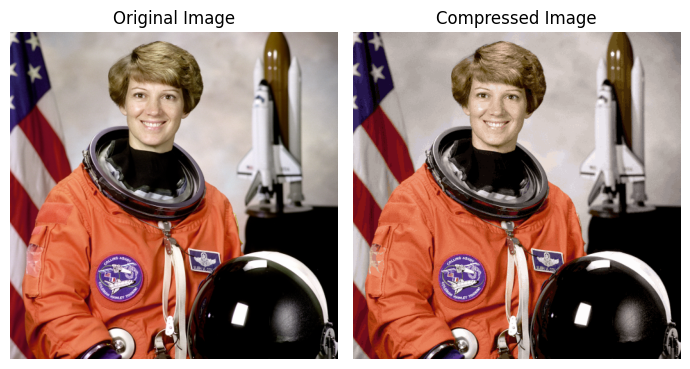

working with 100 clusters...
------------------------------------------------------------------------------------------------------------------------
If we compress our 113382 unique colors into 100 clusters...
The Kmeans inertia is equal to 15467812.665538155


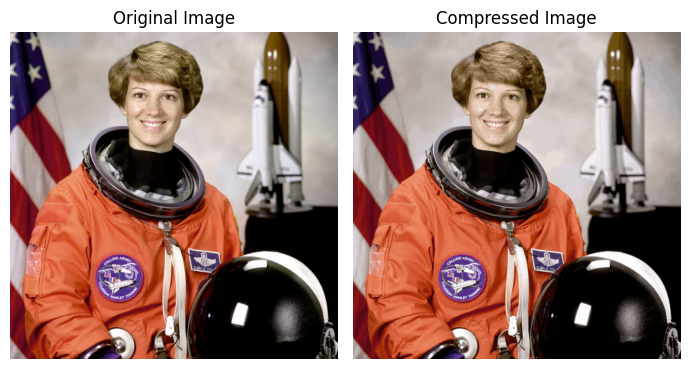

In [133]:
wcss = []
compressed_astronaut = []
for i in [1, 2, 5, 10, 20, 30, 50, 70, 100]:
    print('working with ' + str(i) + ' clusters...', flush=True)
    kmeans = KMeans(n_clusters = i, max_iter=10)
    kmeans.fit(X)
    # compute inertia
    wcss.append(kmeans.inertia_)
    # compute compressed astronaut
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    X_compressed = centers[labels]
    X_compressed = X_compressed.astype('uint8')
    img_compressed = X_compressed.reshape(img_shape[0], img_shape[1], img_shape[2])
    compressed_astronaut.append(img_compressed)
    # printing
    print("-"*120)
    print(f"If we compress our 113382 unique colors into {i} clusters...")
    print(f"The Kmeans inertia is equal to {kmeans.inertia_}")
    fig, ax = plt.subplots(1, 2, figsize = (7, 7))
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[1].imshow(img_compressed)
    ax[1].set_title('Compressed Image')
    for ax in fig.axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()